In [1]:
# simple generative adversarial network
# this version uses a very simple neural network
# aim is to see the adversarial concept working

In [2]:
# conventional PyTorch imports
import torch
import torch.nn as nn
#import torch.nn.functional as F

In [3]:
import random
import pandas

In [4]:
import numpy
import matplotlib.pyplot as plt

In [5]:
# function to generate real data

def generate_real():
    t = torch.FloatTensor([random.uniform(0.8, 1.0),
                           random.uniform(0.0, 0.2),
                           random.uniform(0.8, 1.0),
                           random.uniform(0.0, 0.2)]).view(1, 4)
    return t

In [6]:
# function to generate uniform random data

def generate_random():
    t = torch.FloatTensor([random.uniform(0.0, 1.0),
                           random.uniform(0.0, 1.0),
                           random.uniform(0.0, 1.0),
                           random.uniform(0.0, 1.0)]).view(1, 4)
    return t

In [7]:
# function to generate false data

def generate_false():
    t = torch.FloatTensor([random.uniform(0.0, 0.2),
                           random.uniform(0.8, 1.0),
                           random.uniform(0.0, 0.2),
                           random.uniform(0.8, 1.0)]).view(1, 4)
    return t

In [8]:
# check outputs of the data generation functions

print(generate_real())
print(generate_random())

tensor([[0.8341, 0.1789, 0.9855, 0.0536]])
tensor([[0.4542, 0.4133, 0.2348, 0.1771]])


In [9]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define the layers and their sizes, turn off bias
        self.linear_ih = nn.Linear(4, 3, bias=False)
        self.linear_ho = nn.Linear(3, 1, bias=False)
        
        # define activation function
        self.activation = nn.Sigmoid()
        
        # create error function
        self.error_function = torch.nn.MSELoss()

        # create optimiser, using simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        
        # accumulator for progress
        self.progress = []
        pass
    
    
    def forward(self, inputs):        
        # combine input layer signals into hidden layer
        hidden_inputs = self.linear_ih(inputs)
        # apply sigmiod activation function
        hidden_outputs = self.activation(hidden_inputs)
        
        # combine hidden layer signals into output layer
        final_inputs = self.linear_ho(hidden_outputs)
        # apply sigmiod activation function
        final_outputs = self.activation(final_inputs)
        
        return final_outputs
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        output = self.forward(inputs)
        
        # calculate error
        loss = self.error_function(output, targets)
        
        # accumulate error
        self.progress.append(loss.item())

        # zero gradients, perform a backward pass, and update the weights.
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 0.5), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [10]:
# test discriminator itself works

D = Discriminator()

for i in range(10000):
    D.train(generate_real(), torch.FloatTensor([1.0]))
    D.train(generate_false(), torch.FloatTensor([0.0]))
    #D.train(generate_random(), torch.FloatTensor([1.0]))
    #D.train(generate_random(), torch.FloatTensor([0.0]))
    pass

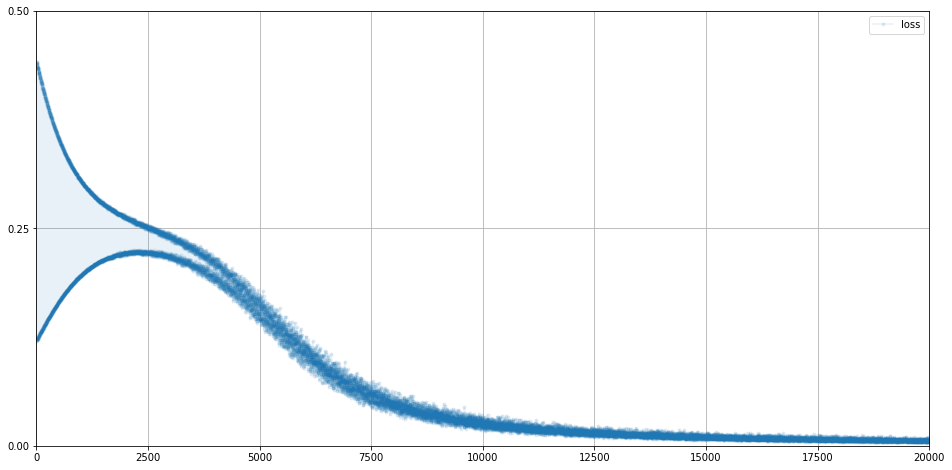

In [11]:
# plot discriminator error

D.plot_progress()

In [12]:
# manually run discriminator to check it can tell real data from fake

print( D.forward(torch.FloatTensor([0.0, 1.0, 0.0, 1.0])).item() )
print( D.forward(torch.FloatTensor([1.0, 0.0, 1.0, 0.0])).item() )

0.057855308055877686
0.9385900497436523


In [13]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define the layers and their sizes, turn off bias
        self.linear_ih = nn.Linear(4, 4, bias=False)
        self.linear_ho = nn.Linear(4, 4, bias=False)
        
        # define activation function
        self.activation = nn.Sigmoid()
        
        # create error function
        self.error_function = torch.nn.MSELoss()

        # create optimiser, using simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        
        # accumulator for progress
        self.progress = []
        
        # counter and array for outputting images
        self.counter = 0;
        self.image_array_list = [];
        pass
    
    
    def forward(self, inputs):        
        # combine input layer signals into hidden layer
        hidden_inputs = self.linear_ih(inputs)
        # apply sigmiod activation function
        hidden_outputs = self.activation(hidden_inputs)
        
        # combine hidden layer signals into output layer
        final_inputs = self.linear_ho(hidden_outputs)
        # apply sigmiod activation function
        final_outputs = self.activation(final_inputs)
        
        return final_outputs
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.error_function(d_output, targets)
        
        # calculate how far wrong the generator for purposes of plotting
        # note we're using knowledge about real data here
        g_loss = self.error_function(g_output, torch.FloatTensor([0.9, 0.0, 0.9, 0.0]))
        
        # accumulate error
        self.progress.append(g_loss.item())

        # zero gradients, perform a backward pass, and update the weights.
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        
        # increase counter and add row to image
        self.counter += 1;
        if (self.counter % 1000 == 0):
            self.image_array_list.append(g_output.detach().numpy())
            pass
        
        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 0.5), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    
    def plot_images(self):
        plt.figure(figsize = (16,8))
        plt.imshow(numpy.concatenate(self.image_array_list).T, interpolation='none', cmap='Blues')
        pass
    
    pass

In [14]:
# create Discriminator and Generator

D = Discriminator()
G = Generator()


# train Discriminator and Generator

for i in range(10000):
    
    # train discriminator on true
    D.train(generate_real(), torch.FloatTensor([1.0]))
    
    # train discriminator on false
    # use detach() so only D is updated, not G
    D.train(G.forward(generate_random()).detach(), torch.FloatTensor([0.0]))
    
    # train generator
    G.train(D, generate_random(), torch.FloatTensor([1.0]))
    
    pass

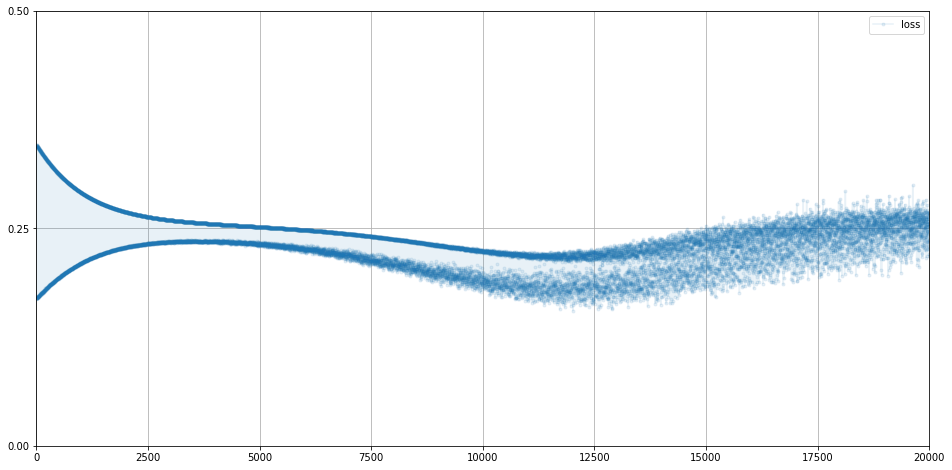

In [15]:
# plot discriminator error

D.plot_progress()

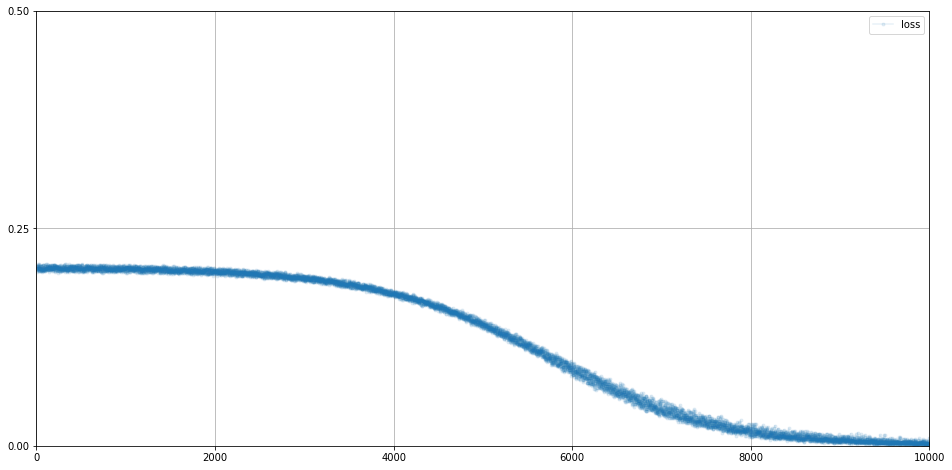

In [16]:
# plot generator error

G.plot_progress()

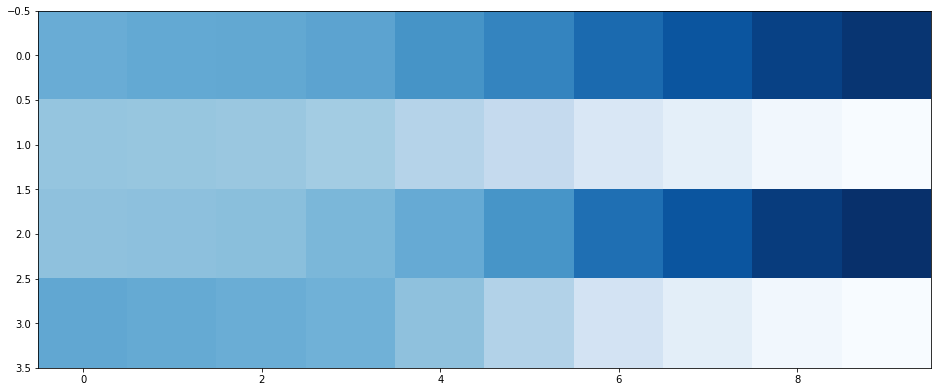

In [17]:
# show generator outputs as they evolve

G.plot_images()

In [18]:
# manually run generator to see it's outputs

print(G.forward(generate_random()))
print(G.forward(generate_random()))
print(G.forward(generate_random()))
print(G.forward(generate_random()))

tensor([[0.8611, 0.0732, 0.8768, 0.0689]], grad_fn=<SigmoidBackward>)
tensor([[0.8582, 0.0776, 0.8686, 0.0729]], grad_fn=<SigmoidBackward>)
tensor([[0.8635, 0.0721, 0.8748, 0.0681]], grad_fn=<SigmoidBackward>)
tensor([[0.8399, 0.0898, 0.8555, 0.0857]], grad_fn=<SigmoidBackward>)
